## Summary

----

## Imports

In [1]:
import concurrent.futures
import concurrent.futures.process
import importlib
import os
import shlex
import shutil
import subprocess
import sys
import warnings
from functools import partial
from itertools import islice
from pathlib import Path

import numpy as np
import yaml
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import psutil
import pyarrow as pa
import pyarrow.parquet as pq
from kmbio import PDB
from kmtools import structure_tools

/home/strokach/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


In [2]:
%matplotlib inline

pd.set_option("max_columns", 100)

In [3]:
SRC_PATH = Path.cwd().joinpath('..', 'src').resolve(strict=True)

if SRC_PATH.as_posix() not in sys.path:
    sys.path.insert(0, SRC_PATH.as_posix())

import helper
importlib.reload(helper)

<module 'helper' from '/home/kimlab1/database_data/datapkg/adjacency-net-v2/src/helper/__init__.py'>

## Parameters

In [4]:
NOTEBOOK_PATH = Path(os.getenv("CI_JOB_NAME", "03_add_adjacency_distances"))
NOTEBOOK_PATH

PosixPath('03_add_adjacency_distances')

In [5]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/03_add_adjacency_distances')

In [6]:
Path.cwd().expanduser()

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks')

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
ADJACENCY_MATRIX_PARQUET_PATH = os.getenv("ADJACENCY_MATRIX_PARQUET_PATH")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None
ADJACENCY_MATRIX_PARQUET_PATH = (
    Path(ADJACENCY_MATRIX_PARQUET_PATH).expanduser() if ADJACENCY_MATRIX_PARQUET_PATH is not None else None
)

TASK_ID, TASK_COUNT, ADJACENCY_MATRIX_PARQUET_PATH

(None, None, None)

In [8]:
DEBUG = "CI" not in os.environ    

if DEBUG:
    TASK_ID = 78
    TASK_COUNT = 1029
    ADJACENCY_MATRIX_PARQUET_PATH = (
        Path(os.getenv("DATAPKG_OUTPUT_DIR"))
        .joinpath("adjacency-net-v2", "v0.3", "training_dataset", "adjacency_matrix.parquet")
    )
else:
    assert TASK_ID is not None
    assert TASK_COUNT is not None
    assert ADJACENCY_MATRIX_PARQUET_PATH is not None

assert ADJACENCY_MATRIX_PARQUET_PATH.is_dir()

TASK_ID, TASK_COUNT, ADJACENCY_MATRIX_PARQUET_PATH

(78,
 1029,
 PosixPath('/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/v0.3/training_dataset/adjacency_matrix.parquet'))

In [9]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

## `DATAPKG`

In [10]:
DATAPKG = {}

In [11]:
DATAPKG["pdb-ffindex"] = {
    "pdb_mmcif_ffindex": (
        Path(os.environ["DATAPKG_OUTPUT_DIR"]).joinpath("pdb-ffindex", "2018-09-06", "pdb-mmcif")
    )
}

## Load data

In [12]:
files = sorted([f for f in ADJACENCY_MATRIX_PARQUET_PATH.glob("**/*.parquet") if f.is_file()])

print(files[:2])
print(len(files))

[PosixPath('/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/v0.3/training_dataset/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.10.10/part-00000-3b8a9efe-9588-498e-bb62-742bb68b4eb5-c000.snappy.parquet'), PosixPath('/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/v0.3/training_dataset/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.10.180/part-00000-53479571-ef99-4995-bf26-90d1fad763a8-c000.snappy.parquet')]
1027


In [13]:
{f.parent.parent for f in files}

{PosixPath('/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/v0.3/training_dataset/adjacency_matrix.parquet')}

In [14]:
chunk_size = int(np.ceil(len(files) / TASK_COUNT))
if len(files) > chunk_size:
    files = files[(TASK_ID - 1) * chunk_size:TASK_ID * chunk_size]

print(len(files))

1


In [15]:
df = (
    pq.ParquetFile(files[0])
    .read_row_group(0, use_pandas_metadata=True)
    .to_pandas(integer_object_nulls=True)
    .set_index("__index_level_0__")
)

In [16]:
df.head(2)

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected
__index_level_0__,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
603433484,UPI000010371B,MGKTYSSPANPIPKAPKGLAIHHWLNFLQAAYRLQPGPSEFDFHQL...,Gene3D,Delta-retroviral matrix superfamily,IPR036989,1,128,128,1JVR,0.0,A,66.99,103.0,30.0,1.0,1.0,103.0,2.0,100.0,-43.00000,144.0,MGKTYSSPANPIPKAPKGLAIHHWLNFLQAAYRLQPGPSEFDFHQL...,MGQIHGLSPTPIPKAPRGLSTHHWLNFLQAAYRLQPGPSDFDFQQL...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...","[2.0, 3.0, 4.0, 6.0, 7.0, 1.0, 3.0, 4.0, 6.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, ...","[3.0, 4.0, 5.0, 7.0, 8.0, 2.0, 4.0, 5.0, 7.0, ...","[M, M, M, M, M, G, G, G, G, G, G, Q, Q, Q, Q, ...","[G, Q, I, G, L, M, Q, I, G, L, I, M, G, I, H, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 5.0, 6.0, 0.0, 2.0, 3.0, 5.0, ..."
55844495,UPI000B5703DB,MGQIFSRSASPIPRPPRGLAAHHWLNFLQAAYRLEPGPSSYDFHQL...,Gene3D,Delta-retroviral matrix superfamily,IPR036989,1,129,129,1JVR,0.0,A,58.09,136.0,49.0,2.0,1.0,129.0,2.0,136.0,-44.30103,147.0,MGQIFSRSASPIPRPPRGLAAHHWLNFLQAAYRLEPGPSSYDFHQL...,MGQIHGLSPTPIPKAPRGLSTHHWLNFLQAAYRLQPGPSDFDFQQL...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...","[2.0, 3.0, 4.0, 6.0, 7.0, 1.0, 3.0, 4.0, 6.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, ...","[3.0, 4.0, 5.0, 7.0, 8.0, 2.0, 4.0, 5.0, 7.0, ...","[M, M, M, M, M, G, G, G, G, G, G, Q, Q, Q, Q, ...","[G, Q, I, G, L, M, Q, I, G, L, I, M, G, I, H, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 5.0, 6.0, 0.0, 2.0, 3.0, 5.0, ..."


## Run pipeline

### Test on a single row

In [17]:
row = list(islice(df.itertuples(), 3))[0]

In [18]:
STRUCTURE_URL_PREFIX = f"ff://{DATAPKG['pdb-ffindex']['pdb_mmcif_ffindex']}?"
STRUCTURE_URL_PREFIX

'ff:///home/kimlab1/database_data/datapkg_output_dir/pdb-ffindex/2018-09-06/pdb-mmcif?'

In [19]:
results = helper.get_adjacency_with_distances_and_orientations(
    row, max_cutoff=12, min_cutoff=None, structure_url_prefix=STRUCTURE_URL_PREFIX
)

In [20]:
ar = results["distance"]

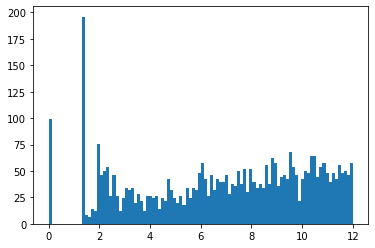

In [21]:
fg, ax = plt.subplots()
ax.hist(ar.to_pylist(), range=(0, 12), bins=100)
None

In [22]:
pa.RecordBatch.from_arrays(list(results.values()), list(results.keys()))

### Test as part of a multiprocessing worker

In [23]:
def worker(data):
    row = helper.to_namedtuple(data)

    results = None
    failures = None

    try:
        results = helper.get_adjacency_with_distances_and_orientations(
            row, max_cutoff=12, min_cutoff=None, structure_url_prefix=STRUCTURE_URL_PREFIX
        )
    except Exception as e:
        failures = {"error": pa.array([f"{type(e)}: {e}"])}

    for column in [
        "Index",
        "uniparc_id",
        "sequence",
        "database",
        "interpro_name",
        "interpro_id",
        "domain_start",
        "domain_end",
        "domain_length",
        "structure_id",
        "model_id",
        "chain_id",
        "pc_identity",
        "alignment_length",
        "mismatches",
        "gap_opens",
        "q_start",
        "q_end",
        "s_start",
        "s_end",
        "evalue_log10",
        "bitscore",
        "qseq",
        "sseq",
    ]:
        if results is not None:
            results[column] = pa.array([data[column]])
        if failures is not None:
            failures[column] = pa.array([data[column]])

    for column in ["a2b", "b2a", "residue_id_1", "residue_id_2", "residue_aa_1", "residue_aa_2"]:
        if data[column].dtype in (int, float):
            values = [(int(i) if pd.notnull(i) else None) for i in data[column]]
        else:
            values = data[column].tolist()
        if results is not None:
            results[column] = pa.array([values])
        if failures is not None:
            failures[column] = pa.array([values])

    return results, failures

In [24]:
worker(row._asdict())

({'residue_idx': <pyarrow.lib.ListArray object at 0x7fc5cf1fafa8>
  [
    [
      0,
      1,
      2,
      3,
      4,
      5,
      6,
      7,
      8,
      9,
      ...
      89,
      90,
      91,
      92,
      93,
      94,
      95,
      96,
      97,
      98
    ]
  ], 'dssp': <pyarrow.lib.ListArray object at 0x7fc5cf1fa228>
  [
    [
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      ...
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C",
      "C"
    ]
  ], 'phi': <pyarrow.lib.ListArray object at 0x7fc5cf1faee8>
  [
    [
      nan,
      2.3355,
      -2.64095,
      1.09293,
      1.35925,
      2.44102,
      0.710764,
      -1.36009,
      -1.30914,
      0.76484,
      ...
      -1.59157,
      -1.57596,
      0.877413,
      -2.02763,
      -1.30944,
      -1.57442,
      -0.689721,
      -1.30898,
      -3.08992,
      2.93572
    ]
  ], 'psi': <pyar

### Run for all rows

In [25]:
def get_new_file(file, failed=False):
    file_parts = list(file.parts)
    file_parts[-4] = file_parts[-4] + "_wdistances" + ("_failed" if failed else "")
    new_file = Path(*file_parts)
    return new_file

In [ ]:
for file in tqdm(files):
    ds = pq.ParquetFile(file)

    new_file = get_new_file(file)
    new_file.parent.mkdir(parents=True, exist_ok=True)
    writer = None

    new_file_failed = get_new_file(file, failed=True)
    new_file_failed.parent.mkdir(parents=True, exist_ok=True)
    writer_failed = None

    for row_group in tqdm(range(ds.num_row_groups), leave=False):
        df = (
            ds.read_row_group(row_group, use_pandas_metadata=True)
            .to_pandas(integer_object_nulls=True)
            .set_index("__index_level_0__")
        )
        try:
            with concurrent.futures.ProcessPoolExecutor(psutil.cpu_count(logical=False)) as pool:
                futures = pool.map(worker, (t._asdict() for t in df.itertuples()), chunksize=1)
                results, failures = list(zip(*list(tqdm(futures, leave=False, total=len(df)))))

            num_failures = sum(1 for r in results if r is None)
            results = [r for r in results if r is not None]
            failures = [f for f in failures if f is not None]
            assert len(failures) == num_failures
            if num_failures:
                print(f"Encountered {num_failures} errors when parsing file '{file}'.")
        except concurrent.futures.process.BrokenProcessPool as e:
            warnings.warn(
                f"ProcessPool crashed while processing row_group '{row_group}' in file '{file}'."
                f"The error is '{type(e)}': {e}."
            )
            break

        if results:
            if writer is None:
                result = results[0]
                batch = pa.RecordBatch.from_arrays(list(result.values()), list(result.keys()))
                writer = pa.RecordBatchFileWriter(new_file, batch.schema)
            for result in results:
                batch = pa.RecordBatch.from_arrays(list(result.values()), list(result.keys()))
                writer.write_batch(batch)

        if failures:
            if writer_failed is None:
                failure = failures[0]
                batch = pa.RecordBatch.from_arrays(list(failure.values()), list(failure.keys()))
                writer_failed = pa.RecordBatchFileWriter(new_file_failed, batch.schema)
        for failure in failures:
            batch = pa.RecordBatch.from_arrays(list(failure.values()), list(failure.keys()))
            writer_failed.write_batch(batch)

    if writer is not None:
        writer.close()

    if writer_failed is not None:
        writer_failed.close()

In [ ]:
!ls -lSh {new_file}